# Research Notebook
## Jayce Scott
## Date: February 18 2025

# 1: Experience
## Describe at least one research activity you worked on this week. 

 - Developed code for Solving the Bondi-Hoyle accretion rate function for Boson Stars. 
 - Worked on the implemenation of Previous weeks in C for improved efficency. 
 - Attended the weekly research group meeting, where we discussed the results and outlined the next steps.

## Motivation:

This week's activities were driven by the need to enhance computational efficiency and accuracy in our simulations. We also began by Implementing the previous weeks work in C  to optimize performance. We also further exlplored how we could use the mass-radius curves in the previous week to solve the Bondi-Hoyle accretion rate function for Boson Stars. The discussions in our research group meeting provided further guidance in steps going forward such as exploring the 2 fluid case for the TOV equations and exploring the wavelength as hydrogen particle falls into a boson star.




# 2: What? (What happened?)
## Describe what happened during your activities for the week.

This week’s focus was on implementing and optimizing the model developed over previous weeks that simulates the mass-radius relationship of a relativistic object using the Tolman-Oppenheimer-Volkoff (TOV) equations. Initially, We defined our equations for the 1 fluid case in Python as described in the paper by Pitz and Schaffner-Bielich (2024). For the sake of simplicity and overall consistency with the aforementioned paper we opted to have Physical constants, such as the gravitational constant and the speed of light  defined in dimensionless quantities.

To further enhance the performance of our code, C code is being integrated to optimize the numerical solution of the TOV equations. This optimization is crucial for improving computational efficiency, especially as the model scales to larger and more complex systems/quantities. The C code is expected to reduce the runtime of the numerical integration, ensuring that the solution remains accurate while significantly speeding up the process of arriving at our numerical solution.

The C code generates the TOV equations numerically via the RK45 method and saves the result as a separate csv file. This csv file can then be opened in python for data analysis. The benefit of this is that once the results are completed we do not need to rerun the code to plot the results of our numerical solutions. Of course this is still a work in progress and as such is not complete yet.

Additionally, we began modeling the Bondi-Hoyle radiation in Python this week. This radiation mechanism is being implemented to study the effects of mass transfer and energy loss in the system as a boson star moves through a large interstellar medium of mostly hydrogen gas. The Python model is designed to simulate this accretion process and radiation output based on variable parameters of the system.

This week’s activities are laying the groundwork for a more comprehensive study of relativistic objects, combining both theoretical modeling and computational optimization. The equation used for the Accretion rate can be found below (Rosswag 2007):


$$
\frac{d\dot{M}}{dr} = \frac{4 \pi G^2 M^2 P}{(c_s^2 + v^2)^{3/2}}
$$



where:

- \( \dot{M} \) is the mass accretion rate,
- \( M \) is the mass of the accreting object,
- \( r \) is the radial coordinate,
- \( P \) is the Energy density of the surrounding Interstellar medium,
- \( G \) is the gravitational constant,
- \( c_s \) is the sound speed in the medium,
- \( v \) is the relative velocity between the accreting object and the medium,
- \(\epsilon(p)  \) is the energy density as a function of pressure,
- \( p \) is the pressure,
- \( \epsilon_0 \) is a constant energy density parameter,
- \( n \) is the polytropic index.


The equations used in the C code for the TOV Equations which can be found in Pitz and Schaffner-Bielich (2024) are found below:

$$
\frac{dm}{dr} = 4 \pi r^2 \epsilon
$$

and 

$$
\frac{dp}{dr} = \frac{(\epsilon + p) (m + 4 \pi r^3 p)}{r(r-2m)}
$$


with the Polytropic equation of state as: 

$$
\epsilon(p) = \epsilon_0 \left( \frac{p}{\epsilon_0} \right)^{\frac{2}{n}} + \frac{n+2}{n-2} p
$$

where:

- \( p \) is the pressure,
- \( r \) is the radial coordinate,
- \( m(r) \) is the mass enclosed within radius \( r \),
- \(\epsilon\) is the initnal energy density (this is dependant on the system), 
- \( G \) is the gravitational constant,
- \( c \) is the speed of light.
- \( \epsilon(p) \) is the energy density,
- \( p \) is the pressure,
- \( \epsilon_0 \) is a constant energy density parameter,
- \( n \) is the polytropic index

(Note that these quantities are dimensionless)

The code for this week can be found below: 

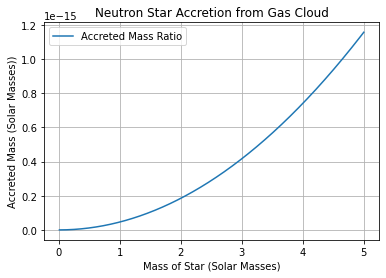

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-8  # cm^3 g^-1 s^-2 (Gravitational constant)
M_sun = 1.989e33  # g (Solar mass)
rho = 1e9 *1.67e-24*2   # g/cm^3 (Typical interstellar gas density H2)
c_s = 10 * 1e5  # cm/s (Sound speed in gas, 10 km/s)
v_rel = 200 * 1e5  # cm/s (Relative velocity, 50 km/s)
masslistline = np.linspace(0.01*M_sun, 5*M_sun,1000)
massratiolist = []

# Bondi-Hoyle accretion rate function
def bondi_hoyle_accretion(M):  # Units: g/s
    return (4 * np.pi * G**2 * M**2 * rho) / ((v_rel**2 + c_s**2)**(3/2))


# Calculate the accreted mass ratio for each mass
for M in masslistline:
    massratiolist.append(bondi_hoyle_accretion(M))

# Plot Results
plt.plot(masslistline/M_sun,bondi_hoyle_accretion(masslistline)/M_sun, label="Accreted Mass Ratio")
plt.ylabel("Accreted Mass (Solar Masses))")
plt.xlabel("Mass of Star (Solar Masses)")
plt.title("Neutron Star Accretion from Gas Cloud")
plt.legend()
plt.grid()
plt.show()

#Stellar medium breakup

In [13]:
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

#define G 1
#define C 1
#define EPSILON_0 1
#define N 4
#define R_MIN 1e-6
#define R_MAX 10
#define STEP_SIZE 1e-4
#define NUM_PRESSURE_POINTS 10
#define M_PI 3.14159265358979323846

// Energy density function
double energy_density(double p) {
    return (p > 0) ? EPSILON_0 * pow(p / EPSILON_0, 2.0 / N) + (N - 2) / (N + 2.0) * p : 0;
}

// TOV equations
double tov_equations(double r, const double y[], double dydr[], void *params) {
    double p = y[0], m = y[1];
    double epsilon = energy_density(p);

    if (p <= 0 || r <= 0 || r - 2 * m <= 0) {
        dydr[0] = 0;
        dydr[1] = 0;
        return 0; 
    }

    // TOV equations
    dydr[0] = -(epsilon + p) * (m + 4 * M_PI * pow(r, 3) * p) / (r * (r - 2 * m));
    dydr[1] = 4 * M_PI * pow(r, 2) * epsilon;

    return 0; 
}

// Solve TOV equations for a given p0 and save to the provided file
void rk45_tov(double (*f)(double, const double[], double[], void*), double p0, FILE *file) {
    // RK45 parameters
    double r = R_MIN;
    double y[2] = {p0, 0};  

    // Save initial data
    while (r < R_MAX && y[0] > 0) {
        fprintf(file, "%e,%e,%e,%e\n", p0, r, y[0], y[1]);
        
        // RK45 integration step
        double k1[2], k2[2], k3[2], k4[2], k5[2], k6[2], ytemp[2];
        double h = STEP_SIZE;

        // k1
        f(r, y, k1, NULL);
        for (int i = 0; i < 2; i++) ytemp[i] = y[i] + 0.5 * h * k1[i];
        
        // k2
        f(r + 0.5 * h, ytemp, k2, NULL);
        for (int i = 0; i < 2; i++) ytemp[i] = y[i] + 0.5 * h * k2[i];
        
        // k3
        f(r + 0.5 * h, ytemp, k3, NULL);
        for (int i = 0; i < 2; i++) ytemp[i] = y[i] + h * k3[i];
        
        // k4
        f(r + h, ytemp, k4, NULL);
        for (int i = 0; i < 2; i++) ytemp[i] = y[i] + (1.0 / 6.0) * h * (k1[i] + 2*k2[i] + 2*k3[i] + k4[i]);
        
        // Update y and r
        for (int i = 0; i < 2; i++) y[i] = ytemp[i];
        r += h;
    }
}

// Main function
int main() {
    double p0_values[NUM_PRESSURE_POINTS];

    // Initialize the p0 values
    for (int i = 0; i < NUM_PRESSURE_POINTS; i++) {
        p0_values[i] = 0.0001 + (99.9999 * i / (NUM_PRESSURE_POINTS - 1));
    }

    // Open a single CSV file to store results
    FILE *file = fopen("rk45_tov_results.csv", "w");
    if (!file) {
        printf("Error opening file for writing.\n");
        return 1;
    }

    // Write the header to the CSV file
    fprintf(file, "Initial Pressure,Radius,Pressure,Mass\n");

    // Parallel execution using OpenMP
    #pragma omp parallel for
    for (int i = 0; i < NUM_PRESSURE_POINTS; i++) {
        // Each iteration writes to the same file, appending data for each p0 value
        rk45_tov(tov_equations, p0_values[i], file);
    }

    // Close the file after writing all results
    fclose(file);

    printf("Simulation complete. Data saved as rk45_tov_results.csv.\n");
    return 0;
}

SyntaxError: invalid syntax (Temp/ipykernel_15552/3169704919.py, line 16)

# 3: So what? (What does it mean?)
## Describe your results

The numerical implementation of the Tolman-Oppenheimer-Volkoff (TOV) equations was successfully modeled in a C environment. This optimization allows for greater computational efficiency and reduced memory use when compared to Python, providing increased flexibility for simulations. The lower memory strain of C will be particularly beneficial as our models grow in complexity and require greater computational resources to compute. Additionally, the Python-based plot for the Bondi-Hoyle accretion function aligns with our theoretical expectations, showing a clear mass dependency in the accretion rate. Specifically, as mass increases, we observe a proportionality to M^2 which is consistent with our equation. These results are promising and form a solid foundation for more advanced studies in the coming weeks.




# 4. Now what? (What's next?)
## Plan for the next week

Next week, the primary objective is to extend the current C code to implement the TOV equations for a two-fluid case, allowing us to study how the interactions between dark matter and baryonic matter affect the mass and radius of the star. Refining the integration method in the C code may also be necessary to ensure accuracy and efficiency with the added complexity (such as switching from the RK45 method). Additionally, the team plans to combine our individual studies on accretion rate, particle potential energy, and the state equation for hydrogen to develop a model that will focus on how a boson star, moving through hydrogen gas, could generate a signal as the hydrogen accretes onto the star. Over the next two weeks, we plan to meet to further refine and collaborate on this goal.

# 5. Bibliography

Your references here

Pitz, S. L., & Schaffner-Bielich, J. (2024). Generating ultra-compact neutron stars with bosonic dark matter. arXiv. https://arxiv.org/abs/2408.13157

Rosswog, S., & Brüggen, M. (2007). Introduction to High-Energy Astrophysics. Cambridge University Press.